<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [186]:
import re
import string
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

nlp = spacy.load('en_core_web_lg')

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [ ]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

from bs4 import BeautifulSoup
import requests

## 2) Use Spacy to tokenize / clean the listings 

In [159]:
##### Your Code Here #####
job_data = pd.read_csv('data/job_listings.csv')
job_data.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [160]:
job_data = job_data.drop(columns='Unnamed: 0')
job_data.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [161]:
job_data.isna().sum()

description    0
title          0
dtype: int64

In [162]:
# Gets rid of html code in description column
job_data['description'] = [BeautifulSoup(text).get_text() for text in job_data['description']]

# Gets rid of the odd characters still in description column
# job_data['description'] = job_data['description'].str.decode("utf-8").replace("\n", " ")
job_data['description'] = job_data['description'].str.replace("b'", ' ')
job_data['description'] = job_data['description'].str.replace('b"', ' ')
# job_data['description'] = job_data['description'].str.decode("utf-8").replace(u"\xe2\x80\x93", " ")

job_data.head()

,description,title
0,Job Requirements:\nConceptual understanding i...,Data scientist
1,"Job Description\n\nAs a Data Scientist 1, you...",Data Scientist I
2,As a Data Scientist you will be working on co...,Data Scientist - Entry Level
3,"$4,969 - $6,756 a monthContractUnder the gene...",Data Scientist
4,Location: USA \xe2\x80\x93 multiple locations...,Data Scientist


In [167]:
# remove the unicode chars (Courtesy of Harsh Desai)
def remove_unicode_chars(df):
    df = df.copy()
    df['description'] = df['description'].str.replace(r'(\\(x|n)[a-z0-9]{0,2})', '')
    return df

job_data = remove_unicode_chars(job_data)
job_data.head()

,description,title,tokens
0,Job Requirements:Conceptual understanding in ...,Data scientist,"[ , job, requirements:\nconceptual, understand..."
1,"Job DescriptionAs a Data Scientist 1, you wil...",Data Scientist I,"[ , job, description\n\nas, data, scientist, 1..."
2,As a Data Scientist you will be working on co...,Data Scientist - Entry Level,"[ , data, scientist, working, consulting, busi..."
3,"$4,969 - $6,756 a monthContractUnder the gene...",Data Scientist,"[ , $4,969, $6,756, monthcontractunder, genera..."
4,Location: USA multiple locations+ years of A...,Data Scientist,"[ , location:, usa, \xe2\x80\x93, multiple, lo..."


In [168]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [169]:
tokens = []

""" Make some tokens """
for doc in tokenizer.pipe(job_data['description']):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    
    tokens.append(doc_tokens)
    
job_data['tokens'] = tokens

In [170]:
job_data.head()

,description,title,tokens
0,Job Requirements:Conceptual understanding in ...,Data scientist,"[ , job, requirements:conceptual, understandin..."
1,"Job DescriptionAs a Data Scientist 1, you wil...",Data Scientist I,"[ , job, descriptionas, data, scientist, 1,, h..."
2,As a Data Scientist you will be working on co...,Data Scientist - Entry Level,"[ , data, scientist, working, consulting, busi..."
3,"$4,969 - $6,756 a monthContractUnder the gene...",Data Scientist,"[ , $4,969, $6,756, monthcontractunder, genera..."
4,Location: USA multiple locations+ years of A...,Data Scientist,"[ , location:, usa, , multiple, locations+, y..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [171]:
##### Your Code Here #####
vect = CountVectorizer(stop_words='english', min_df=0.05, max_df=0.95)

vect.fit(job_data['description'])

sparse_dtm = vect.transform(job_data['description'])

dtm = pd.DataFrame(sparse_dtm.todense(), columns=vect.get_feature_names())

In [172]:
dtm.head()

,000,10,100,2019,abilities,ability,able,academic,access,accommodation,...,world,worlds,write,writing,written,www,year,years,york,youll
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,2,0,0,2,1,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 4) Visualize the most common word counts

In [173]:
import squarify
from collections import Counter

In [174]:
# Just gonna borrow this real quick
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [179]:
STOP_WORDS = nlp.Defaults.stop_words.union(['to', 'and', 'with', 'in', 'the', 'or',
                                            'for', 'a', 'To', 'And', 'With', 'In',
                                            'The', 'Or', 'For', 'A', 'work', 'we',
                                           'Work', 'We', 'new', 'New', ' '])

In [180]:
tokens = []

for doc in tokenizer.pipe(job_data['description']):
    
    doc_tokens = []
    
    for token in doc:
        if token.text not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
            
    tokens.append(doc_tokens)
    
job_data['new_tokens'] = tokens

In [181]:
wc2 = count(job_data['new_tokens'])
wc2.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
39,data,420,3783,1.0,0.029951,0.029951,0.985915
98,business,303,1009,2.0,0.007989,0.037940,0.711268
66,experience,357,947,3.0,0.007498,0.045438,0.838028
315,team,314,728,4.0,0.005764,0.051201,0.737089
17,machine,271,662,5.0,0.005241,0.056443,0.636150
50,learning,267,642,6.0,0.005083,0.061526,0.626761
38,science,229,564,7.0,0.004465,0.065991,0.537559
365,statistical,256,531,8.0,0.004204,0.070195,0.600939
521,analytics,201,520,9.0,0.004117,0.074312,0.471831
319,product,186,464,10.0,0.003674,0.077986,0.436620


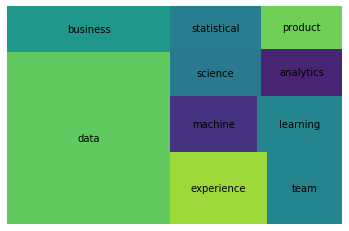

In [182]:
wc2_top = wc2[wc2['rank'] <= 10]

squarify.plot(sizes=wc2_top['pct_total'], label=wc2_top['word'])
plt.axis('off')
plt.show();

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [190]:
def tokenize(document):
    doc = nlp(document)
    return [token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [196]:
##### Your Code Here #####
tfidf = TfidfVectorizer(tokenizer=tokenize, min_df=0.1, max_df=0.9, ngram_range=(1,2))

sparse = tfidf.fit_transform(job_data['description'])

dtm = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

dtm.head()

# raise Exception("\nThis task is not complete. \nReplace this line with your code for the task.")

,$,+,+ year,2,3,5,ability,able,access,achieve,...,work,work closely,work experience,workplace,world,write,write communication,write verbal,year,year experience
0,0.000000,0.000000,0.000000,0.206531,0.0,0.000000,0.112898,0.0,0.0,0.0,...,0.072838,0.0,0.0,0.0,0.000000,0.124665,0.0,0.0,0.000000,0.0
1,0.000000,0.070488,0.081837,0.000000,0.0,0.000000,0.046257,0.0,0.0,0.0,...,0.119372,0.0,0.0,0.0,0.090423,0.153233,0.0,0.0,0.034899,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.132438,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.441179,0.000000,0.000000,0.000000,0.0,0.111727,0.000000,0.0,0.0,0.0,...,0.080958,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.047337,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.212702,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [198]:
from sklearn.neighbors import NearestNeighbors

In [199]:
##### Your Code Here #####
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

Exception: 
This task is not complete. 
Replace this line with your code for the task.

In [201]:
nn.kneighbors([dtm.iloc[356]])

# raise Exception("\nThis task is not complete. \nReplace this line with your code for the task.")

(array([[0.        , 1.13762732, 1.14589768, 1.16132151, 1.1680957 ]]),
 array([[356, 276, 392, 387, 379]], dtype=int64))

In [203]:
job_data['description'][356][:200]

' InternshipOverview:Are you a geek for data? Do you love using analytics to help make decisions? Do you get so excited about coding breakthroughs that you forget about the hours it took you to find an'

In [204]:
query = [""" We are looking for skills with python, machine learning, and natural language processing"""]

In [205]:
looking = tfidf.transform(query)

nn.kneighbors(looking.todense())

(array([[1.07704006, 1.10789565, 1.12304158, 1.15949002, 1.16156289]]),
 array([[254, 311, 239, 180, 283]], dtype=int64))

In [206]:
job_data['description'][254]

" Please review the job details below.Are you excited by the possibilities presented by combining machine learning and the cloud? Do you have the drive to contribute to our nation\\'s security? In an increasingly data-rich environment, threats to our country are harder to detect and require the augmentation of intelligence by machines. As a part of our team, you can help turn this complex problem into a real solution for an important Intelligence Community customer. We are looking to hire a cleared Data Scientist to an established team of motivated data scientists to make the customer\\'s vision a reality.What you will be doing:Contributing to the development and maintenance of NGA Maritimes automated machine learning framework housed in AWS and using natural language processing (NLP)Improving an architecture to ingest naval chart/notice data and other location based intelligence data at scaleLearning and applying NLP to customer dataAssisting NGA in their efforts to migrate the above 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 